In [3]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [4]:
import sys
sys.path.append("../") # go to parent dir
sys.path.append('/home/artem/git/sdafe')

In [5]:
from sdafe.plot import plot_qq_norm

### 10.4.1 Current Population Survey Data

In [6]:
data = pd.read_csv('../data/CPS1988.csv')
data.head()

,wage,education,experience,ethnicity,smsa,region,parttime
0,354.94,7,45,cauc,yes,northeast,no
1,123.46,12,1,cauc,yes,northeast,yes
2,370.37,9,9,cauc,yes,northeast,no
3,754.94,11,46,cauc,yes,northeast,no
4,593.54,12,36,cauc,yes,northeast,no


In [7]:
data['ethnicity'].value_counts()

ethnicity
cauc    25923
afam     2232
Name: count, dtype: int64

In [8]:
data['ethnicity'] = data['ethnicity'].apply(lambda v: 0 if v == 'cauc' else 1)

#### Problem 1

In [9]:
model_def = ols('wage ~ education + experience + ethnicity', data=data)
model_orig = model_def.fit()
model_orig.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     2097.
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:06:11   Log-Likelihood:            -2.0934e+05
No. Observations:               28155   AIC:                         4.187e+05
Df Residuals:                   28151   BIC:                         4.187e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -362.2411     13.295    -27.247      0.000    -388.299    -336.183
education     59.9646      0.882     67.971      0.000      58.235      61.694
experience    10.5787      0.195     54.236      0.000      10.196      10.961
ethnicity   -128.3219      9.072    -14.145      0.000    -146.103    -110.541
==============================================================================
Omnibus:                    40705.622   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         69434162.059
Skew:                           8.068   Prob(JB):                         0.00
Kurtosis:                     245.749   Cond. No.                         137.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
def unzip(x: np.array):
    return x[:, 0], x[:, 1]

In [11]:
def plot_diagnostics(model, data, vars_to_plot=('education', 'experience'), frac=0.2):
    resid1 = model.outlier_test()

    fig, axs = plt.subplots(2, 3, figsize=(16, 10))

    axs[0][0].scatter(model.fittedvalues, resid1['student_resid'], s=1, alpha=0.4);
    axs[0][0].plot(*unzip(lowess(resid1['student_resid'], model.fittedvalues, frac=frac)), color='red', linewidth=2);
    axs[0][0].axhline(0, color='black');
    axs[0][0].set_ylim([-5, 10]);
    axs[0][0].set_title('Studentised residuals vs fitted values');
    axs[0][0].set_xlabel('Fitted value');
    axs[0][0].set_ylabel('Studentised residual');

    axs[0][1].scatter(model.fittedvalues, resid1['student_resid'].abs(), s=1, alpha=0.4);
    axs[0][1].plot(*unzip(lowess(resid1['student_resid'].abs(), model.fittedvalues, frac=frac)), color='red', linewidth=2);
    axs[0][1].axhline(resid1['student_resid'].abs().mean(), color='black');
    axs[0][1].set_ylim([-5, 10]);
    axs[0][1].set_title('Absolute studentised residuals vs fitted values');
    axs[0][1].set_xlabel('Fitted value');
    axs[0][1].set_ylabel('Absolute studentised residual');

    plot_qq_norm(axs[0][2], resid1['student_resid']);

    var_to_plot = vars_to_plot[0]
    axs[1][0].scatter(data[var_to_plot], resid1['student_resid'], s=1, alpha=0.4);
    axs[1][0].plot(*unzip(lowess(resid1['student_resid'], data[var_to_plot], frac=frac)), color='red', linewidth=2);
    axs[1][0].axhline(0, color='black');
    axs[1][0].set_ylim([-5, 10]);
    axs[1][0].set_title(f'Studentised residuals vs {var_to_plot}');
    axs[1][0].set_xlabel(var_to_plot);
    axs[1][0].set_ylabel('Studentised residual');

    var_to_plot = vars_to_plot[1]
    axs[1][1].scatter(data[var_to_plot], resid1['student_resid'], s=1, alpha=0.4);
    axs[1][1].plot(*unzip(lowess(resid1['student_resid'], data[var_to_plot], frac=frac)), color='red', linewidth=2);
    axs[1][1].axhline(0, color='black');
    axs[1][1].set_ylim([-5, 10]);
    axs[1][1].set_title(f'Studentised residuals vs {var_to_plot}');
    axs[1][1].set_xlabel(var_to_plot);
    axs[1][1].set_ylabel('Studentised residual');

    axs[1][2].hist(resid1['student_resid'], bins=100, density=True);
    axs[1][2].set_title('Histogram of studentised residuals');
    axs[1][2].set_xlim([-5, 10]);

/home/artem/Study/SDAFE/venv/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


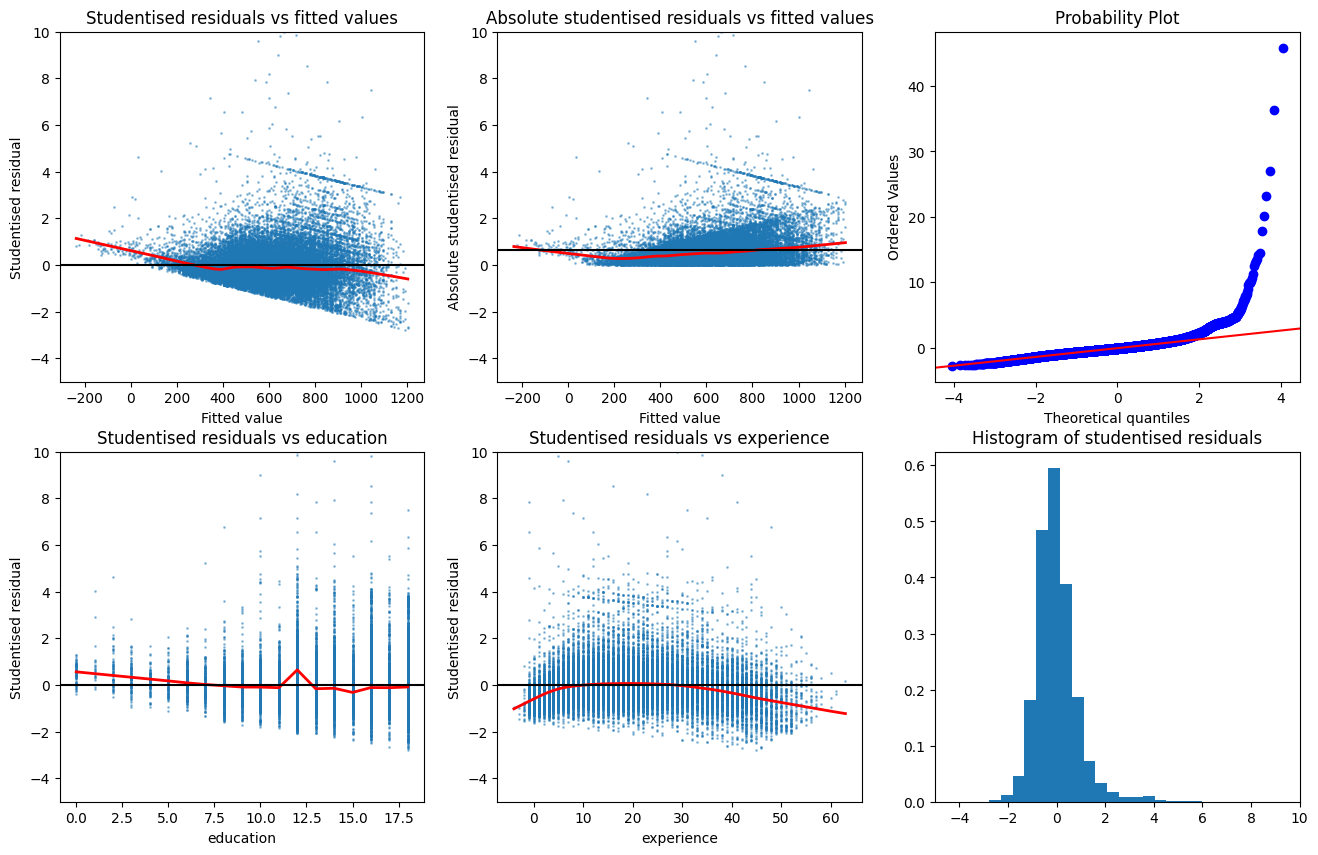

In [12]:
plot_diagnostics(model_orig, data)

The plots of studentised residuals and their absolute values vs fitted values suggest heteroskedasticity: the variation in the residual is higher for higher fitted values.

The QQ plot shows that the distribution of residuals exhibits significant right-skewness.

The plot of studentised residuals against education shows conditional heterskedasticity: the variation in the residuals grows with higher values of education.

The plot of residuals against experience suggest some non-linearity in the corresponding relationship.

This suggests that a transformation of the response variable (e.g. a square root or logarithm) might be appropriate.

#### Problem 2

In [13]:
data['logwage'] = np.log(data['wage'])

In [14]:
model_def = ols('logwage ~ education + experience + ethnicity', data=data)
model = model_def.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                logwage   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     2665.
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:09:31   Log-Likelihood:                -27020.
No. Observations:               28155   AIC:                         5.405e+04
Df Residuals:                   28151   BIC:                         5.408e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.5321      0.020    221.257      0.000       4.492       4.572
education      0.0996      0.001     73.258      0.000       0.097       0.102
experience     0.0196      0.000     65.198      0.000       0.019       0.020
ethnicity     -0.2431      0.014    -17.395      0.000      -0.271      -0.216
==============================================================================
Omnibus:                     2846.769   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4634.595
Skew:                          -0.733   Prob(JB):                         0.00
Kurtosis:                       4.343   Cond. No.                         137.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/home/artem/Study/SDAFE/venv/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


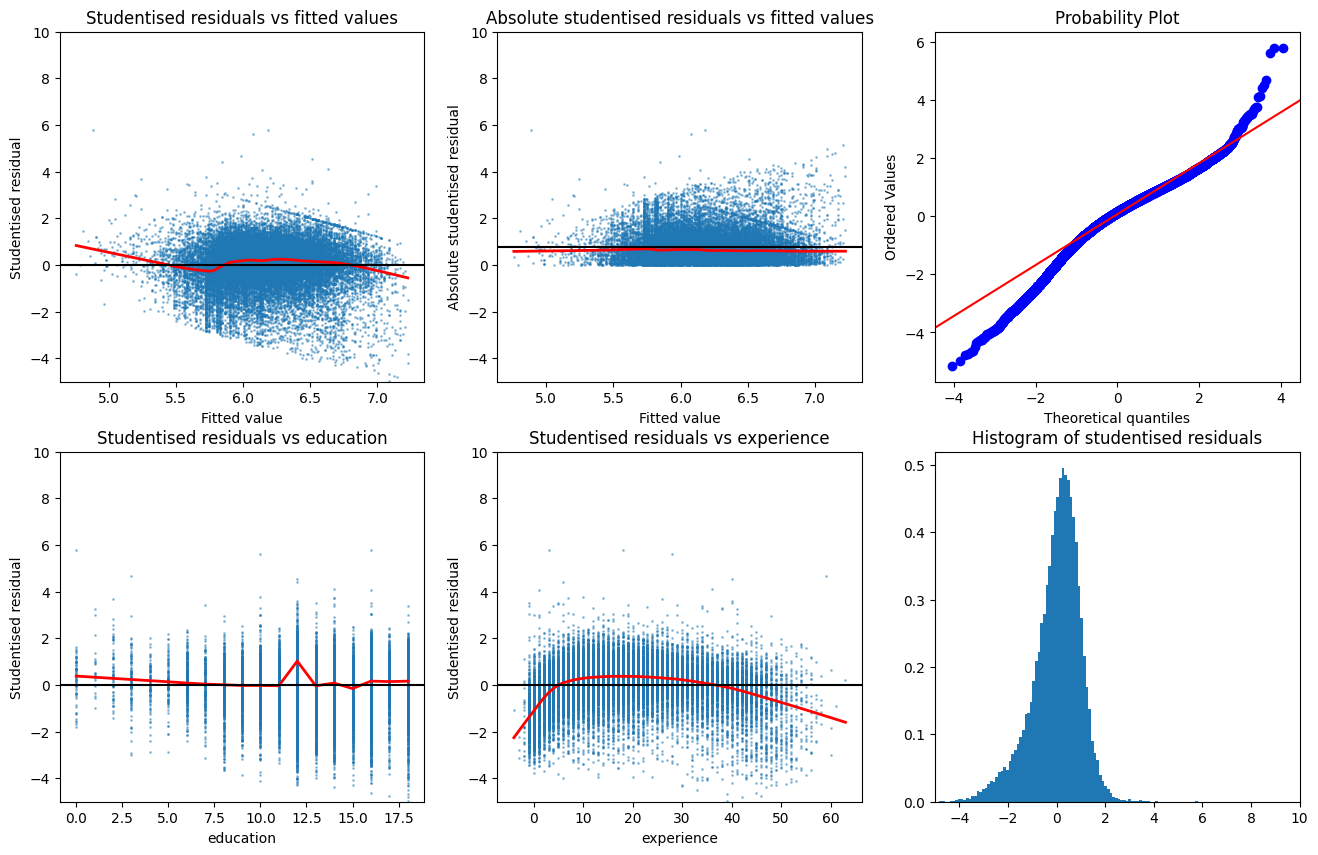

In [15]:
plot_diagnostics(model, data)

The plots of studentised residuals and their absolute values are improved by the log transformation. The skewness is also reduced. The issue with the dependency of residuals on experience, however, remains.

#### Problem 3

Next, we try the model for the square root of the wage.

In [16]:
data['sqrtwage'] = np.sqrt(data['wage'])

In [17]:
model_def = ols('sqrtwage ~ education + experience + ethnicity', data=data)
model = model_def.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               sqrtwage   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     2854.
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:12:49   Log-Likelihood:                -94642.
No. Observations:               28155   AIC:                         1.893e+05
Df Residuals:                   28151   BIC:                         1.893e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2527      0.226     18.801      0.000       3.809       4.696
education      1.1686      0.015     77.851      0.000       1.139       1.198
experience     0.2160      0.003     65.078      0.000       0.209       0.222
ethnicity     -2.6564      0.154    -17.211      0.000      -2.959      -2.354
==============================================================================
Omnibus:                     6634.070   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            75334.106
Skew:                           0.810   Prob(JB):                         0.00
Kurtosis:                      10.848   Cond. No.                         137.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/home/artem/Study/SDAFE/venv/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


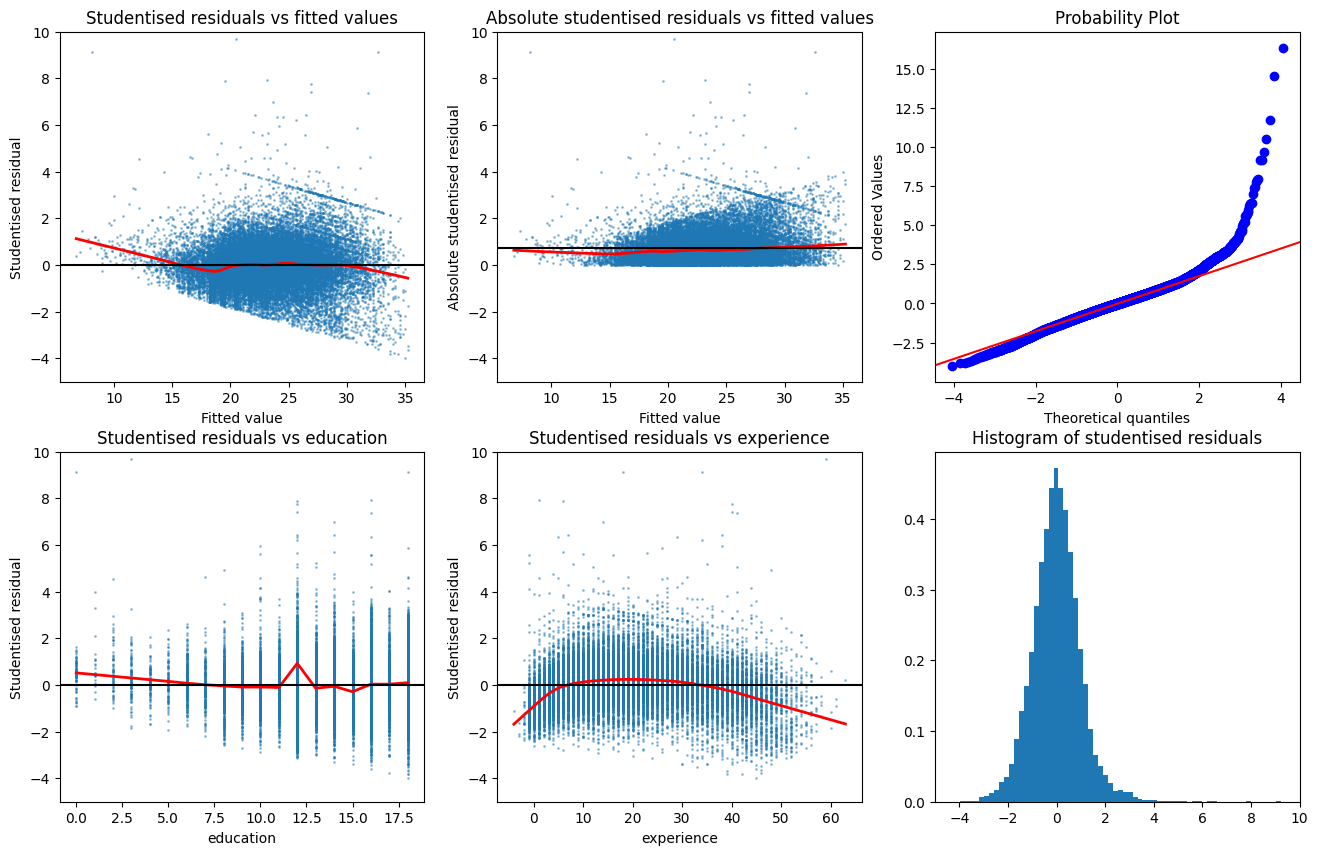

In [18]:
plot_diagnostics(model, data)

The square-root transformation does not seem to improve the situation significantly compared to the log transformation.

Now we will attempt to include the square of demeaned experience.

In [19]:
data['experience'].mean()

18.199928964659918

In [20]:
data['exp'] = data['experience'] - data['experience'].mean()
data['exp_sq'] = data['exp'] ** 2
data['exp_log'] = np.log(data['experience'] + 5)

In [21]:
model_def = ols('logwage ~ education + exp + exp_sq + ethnicity', data=data)
model = model_def.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                logwage   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     3541.
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:16:40   Log-Likelihood:                -24801.
No. Observations:               28155   AIC:                         4.961e+04
Df Residuals:                   28150   BIC:                         4.965e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2955      0.018    296.196      0.000       5.260       5.331
education      0.0857      0.001     67.343      0.000       0.083       0.088
exp            0.0296      0.000     94.520      0.000       0.029       0.030
exp_sq        -0.0013    1.9e-05    -69.312      0.000      -0.001      -0.001
ethnicity     -0.2434      0.013    -18.839      0.000      -0.269      -0.218
==============================================================================
Omnibus:                     2034.828   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3963.309
Skew:                          -0.508   Prob(JB):                         0.00
Kurtosis:                       4.532   Cond. No.                     1.43e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We check the multicollinearity indicated in the fit diagnostics above.

In [22]:
def vif(x):
    x = sm.add_constant(x, prepend=True)
    return pd.Series([variance_inflation_factor(x, i) for i in range(len(x.columns)) if x.columns[i] != 'const'], index=x.columns[1:])

In [23]:
vif(data[['education', 'exp', 'exp_sq', 'ethnicity']])

education    1.123601
exp          1.382242
exp_sq       1.372326
ethnicity    1.005755
dtype: float64

/home/artem/Study/SDAFE/venv/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


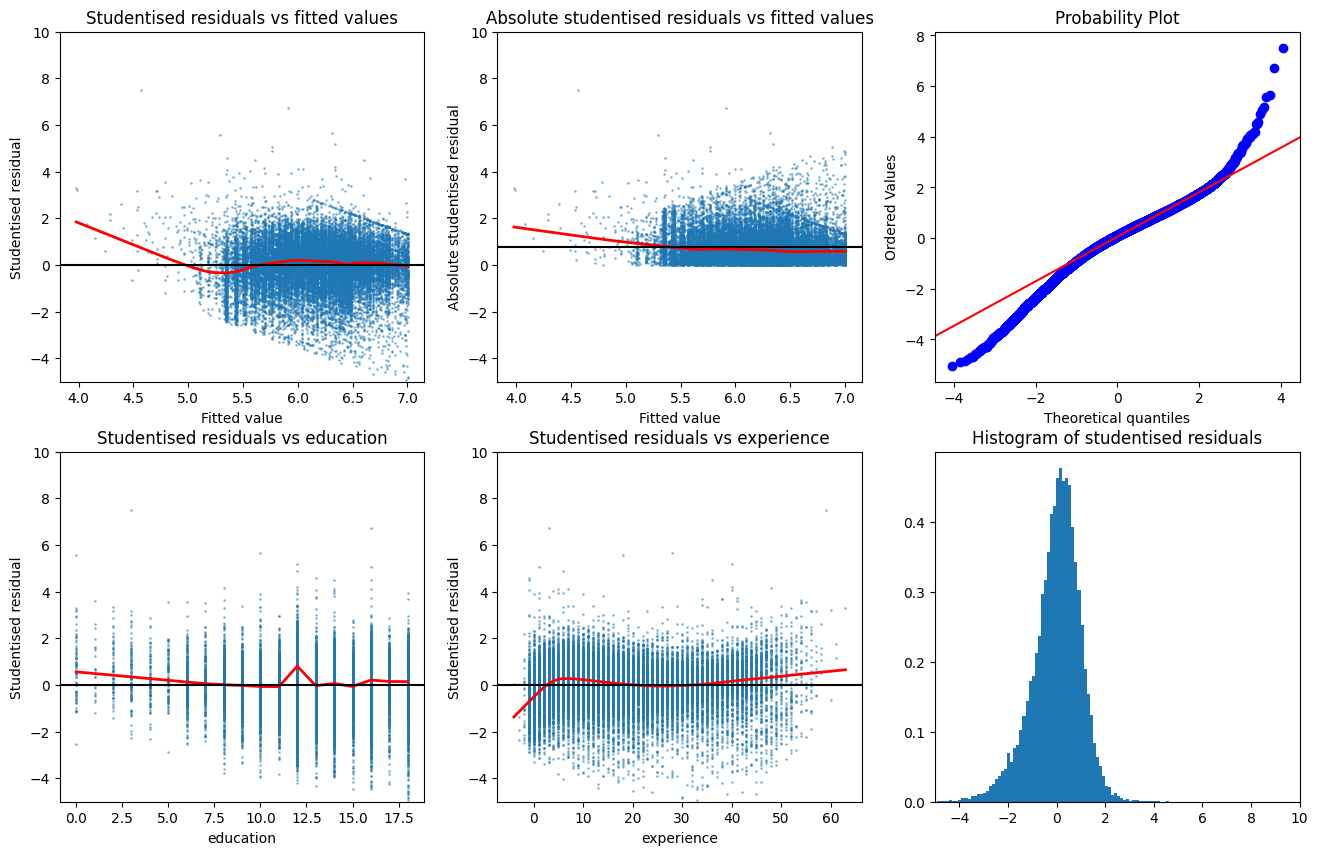

In [24]:
plot_diagnostics(model, data)

We also try a model with log of experience (assuming the dependency tails off).

In [25]:
model_def = ols('logwage ~ education + exp_log + ethnicity', data=data)
model = model_def.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                logwage   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     4049.
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:20:19   Log-Likelihood:                -25490.
No. Observations:               28155   AIC:                         5.099e+04
Df Residuals:                   28151   BIC:                         5.102e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3477      0.027    125.063      0.000       3.295       3.400
education      0.1009      0.001     79.516      0.000       0.098       0.103
exp_log        0.5141      0.006     89.279      0.000       0.503       0.525
ethnicity     -0.2436      0.013    -18.403      0.000      -0.270      -0.218
==============================================================================
Omnibus:                     2969.712   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5657.461
Skew:                          -0.702   Prob(JB):                         0.00
Kurtosis:                       4.689   Cond. No.                         105.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/home/artem/Study/SDAFE/venv/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


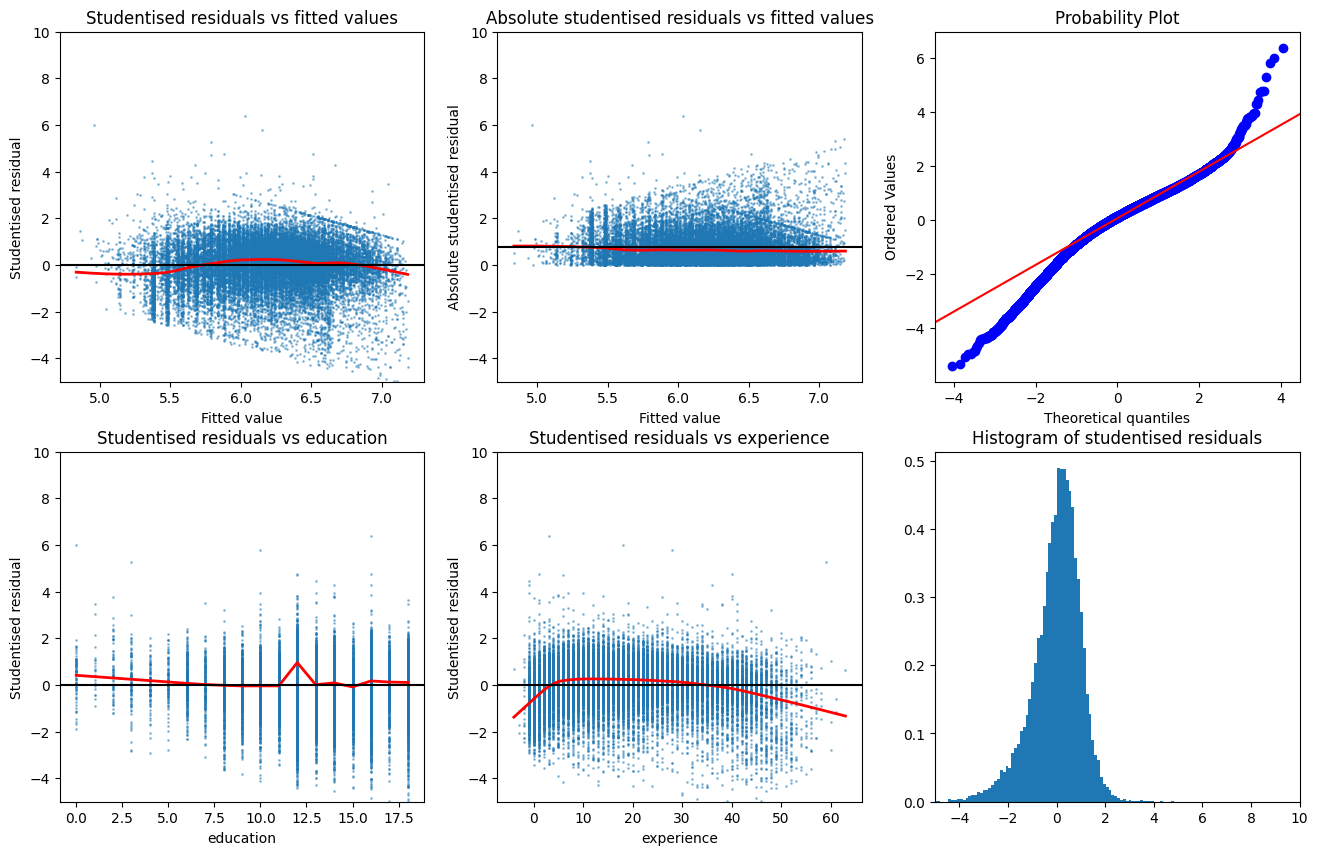

In [26]:
plot_diagnostics(model, data)

#### Problem 4

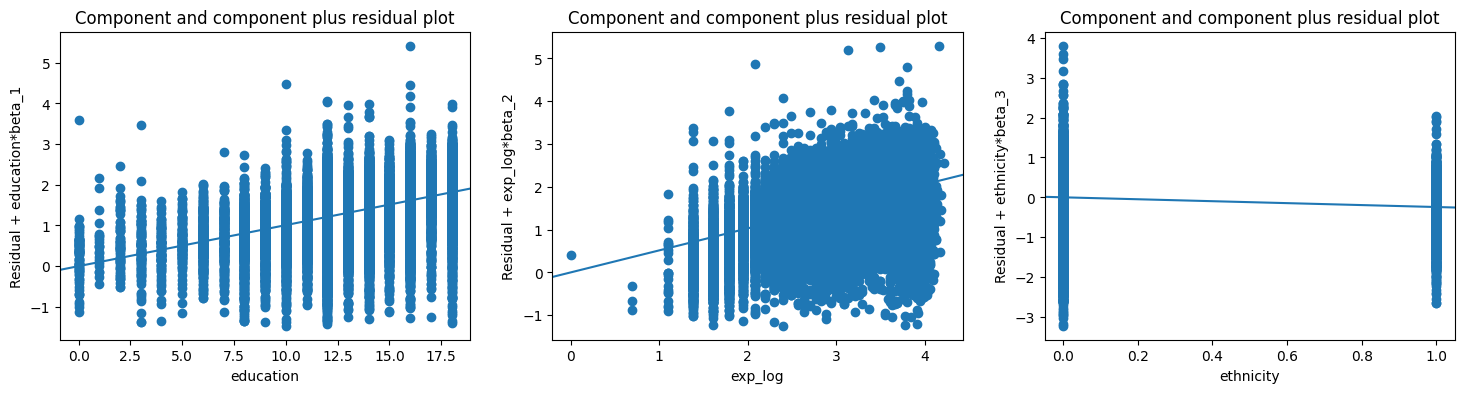

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
sm.graphics.plot_ccpr(model, 'education', ax=axs[0]);
sm.graphics.plot_ccpr(model, 'exp_log', ax=axs[1]);
sm.graphics.plot_ccpr(model, 'ethnicity', ax=axs[2]);

The model suggests that:
   * there is a positive linear dependency between wage and education;
   * the relationship between experience and wage is non-linear: the wage grows with experience when experience is in the region 0-10 yeas, the wage decreases with experience in the region of 40-50 years, and it stays flat in-between those regions;
   * the wage is lower for the African-American group with controlling for the effects of education and experience;
   * all effects are statistically significant at 99.9%.

#### Problem 5

In [32]:
influence = model_orig.get_influence()

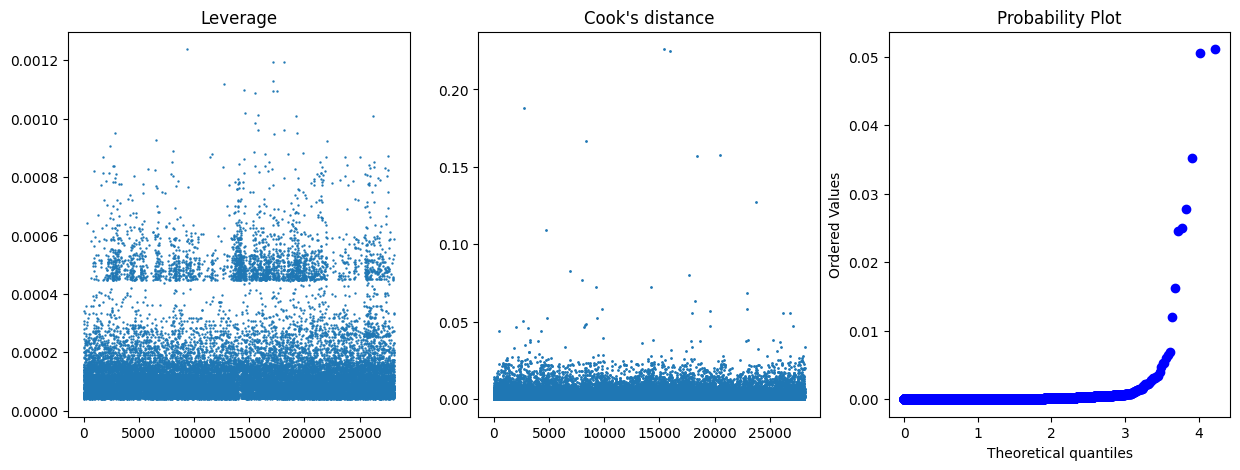

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(np.arange(len(influence.hat_matrix_diag)), influence.hat_matrix_diag, s=0.5);
axs[0].set_title('Leverage');

axs[1].scatter(np.arange(len(influence.cooks_distance[0])), np.sqrt(influence.cooks_distance[0]), s=1);
axs[1].set_title('Cook\'s distance');

stats.probplot(influence.cooks_distance[0], dist="halfnorm", plot=axs[2], fit=False);

The leverage plot suggests that there are two groups of entries in the data. We confirm that those are based on ethnicity:

In [34]:
data[influence.hat_matrix_diag > 0.0004]['ethnicity'].value_counts()

ethnicity
1    2232
0     330
Name: count, dtype: int64

In [35]:
data[influence.hat_matrix_diag <= 0.0004]['ethnicity'].value_counts()

ethnicity
0    25593
Name: count, dtype: int64

We now attempt to fit the original model for the two groups separately.

In [36]:
data[data['ethnicity'] == 0]

,wage,education,experience,ethnicity,smsa,region,parttime,logwage,sqrtwage,exp,exp_sq,exp_log
0,354.94,7,45,0,yes,northeast,no,5.871949,18.839851,26.800071,718.243807,3.912023
1,123.46,12,1,0,yes,northeast,yes,4.815917,11.111256,-17.199929,295.837556,1.791759
2,370.37,9,9,0,yes,northeast,no,5.914503,19.244999,-9.199929,84.638693,2.639057
3,754.94,11,46,0,yes,northeast,no,6.626638,27.476171,27.800071,772.843950,3.931826
4,593.54,12,36,0,yes,northeast,no,6.386105,24.362676,17.800071,316.842529,3.713572
...,...,...,...,...,...,...,...,...,...,...,...,...
28150,356.13,12,13,0,no,west,no,5.875296,18.871407,-5.199929,27.039261,2.890372
28151,308.64,12,8,0,no,west,yes,5.732176,17.568153,-10.199929,104.038551,2.564949
28152,427.35,12,28,0,no,west,no,6.057603,20.672445,9.800071,96.041392,3.496508
28153,834.02,17,30,0,no,west,no,6.726257,28.879404,11.800071,139.241676,3.555348


In [37]:
cauc_only = data[data['ethnicity'] == 0]
black_only = data[data['ethnicity'] == 1]

In [38]:
model_def = ols('wage ~ education + experience', data=cauc_only)
model = model_def.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     2736.
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:38:30   Log-Likelihood:            -1.9331e+05
No. Observations:               25923   AIC:                         3.866e+05
Df Residuals:                   25920   BIC:                         3.866e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -373.2395     14.004    -26.652      0.000    -400.689    -345.790
education     60.5655      0.932     64.950      0.000      58.738      62.393
experience    10.7498      0.208     51.802      0.000      10.343      11.157
==============================================================================
Omnibus:                    37630.666   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         63149379.914
Skew:                           8.142   Prob(JB):                         0.00
Kurtosis:                     244.246   Cond. No.                         134.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/home/artem/Study/SDAFE/venv/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


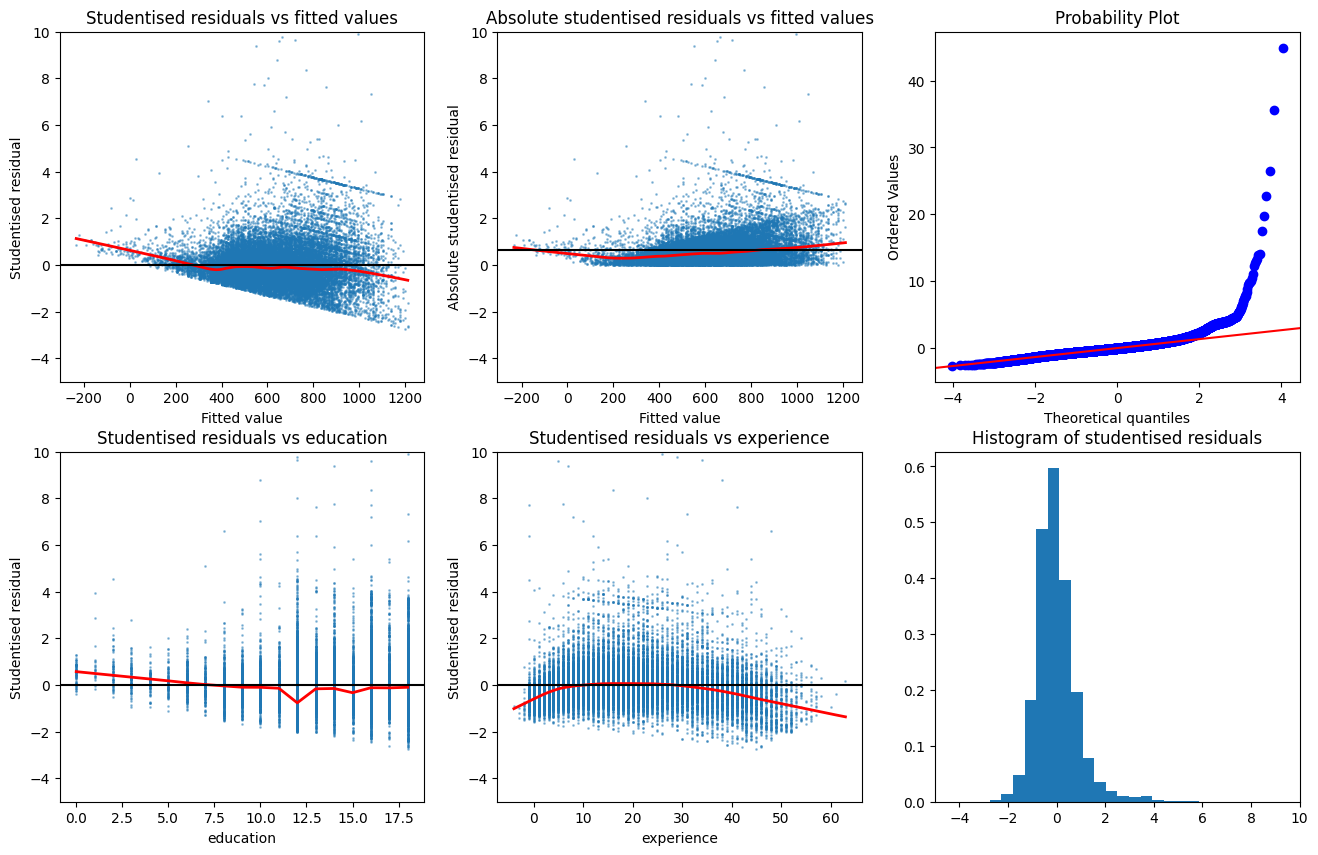

In [39]:
plot_diagnostics(model, cauc_only)

In [40]:
model_def = ols('wage ~ education + experience', data=black_only)
model = model_def.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     246.6
Date:                Mon, 24 Apr 2023   Prob (F-statistic):           1.82e-97
Time:                        18:40:57   Log-Likelihood:                -15765.
No. Observations:                2232   AIC:                         3.154e+04
Df Residuals:                    2229   BIC:                         3.155e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -320.6058     35.416     -9.053      0.000    -390.057    -251.155
education     49.7987      2.416     20.612      0.000      45.061      54.536
experience     8.1964      0.495     16.567      0.000       7.226       9.167
==============================================================================
Omnibus:                     1271.376   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21819.142
Skew:                           2.324   Prob(JB):                         0.00
Kurtosis:                      17.595   Cond. No.                         149.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/home/artem/Study/SDAFE/venv/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


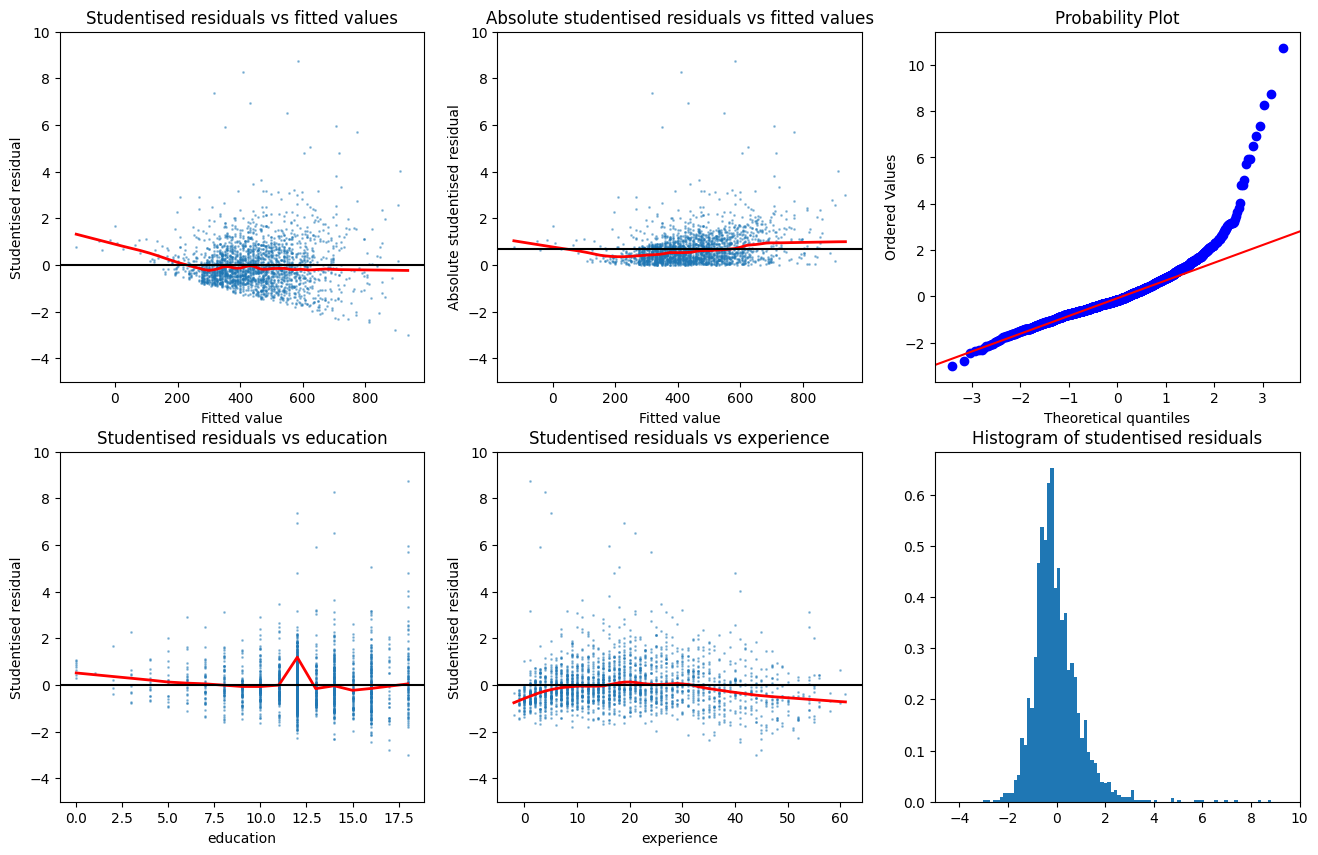

In [41]:
plot_diagnostics(model, black_only)

In [42]:
stats.ttest_ind(cauc_only['wage'], black_only['wage'])

Ttest_indResult(statistic=17.11796330186234, pvalue=2.336803484087594e-65)